In [1]:
import torch
import time
import numpy as np
import subprocess
import yaml
from itertools import product
import random
import math
import matplotlib.pyplot as plt
import gc
import pandas as pd

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
def get_power_limit():
    result = subprocess.run(["nvidia-smi", "--query-gpu=power.limit"], capture_output=True, text=True)
    return float(result.stdout.split('\n')[1].split()[0])

def get_sm_clock():
    result = subprocess.run(["nvidia-smi", "--query-gpu=clocks.max.sm"], capture_output=True, text=True)
    return float(result.stdout.split('\n')[1].split()[0])    

In [4]:
with open("sm_cores.yaml", "r") as file:
    sm_cores = yaml.safe_load(file)

In [5]:
props = torch.cuda.get_device_properties(0)

device_information = {
    "device_name": torch.cuda.get_device_name(0),
    "number_of_sm": props.multi_processor_count,
    "power_limit": get_power_limit(),
    "compute_capability": (props.major, props.minor),
    "cores_per_sm": sm_cores['cuda_cores_per_sm'][f"{props.major}.{props.minor}"],
    "sm_clock": get_sm_clock(),
    "memory": torch.cuda.mem_get_info()[1]
}
device_information["total_number_of_cores"] = device_information["number_of_sm"] * device_information["cores_per_sm"]
device_information["theoretical_flops"] = int(device_information["total_number_of_cores"] * device_information["sm_clock"] * 2 * 1e6)
device_information['theoretical_flops'] / 1e12

24.7296

### Measure flops using events

In [55]:
dtype = torch.float16

In [45]:
str(dtype)

'torch.float32'

In [6]:
memory_overhead = 0.02

In [46]:
def benchmark_gemm(M, N, K, device, dtype, n_warmup, n_repeat):
    A = torch.rand(M, N, device = device, requires_grad=False, dtype = dtype)
    B = torch.rand(N, K, device = device, requires_grad=False, dtype = dtype)
    C = torch.rand(M, K, device = device, requires_grad=False, dtype = dtype)
    total_time = np.empty((n_repeat))
    flops = np.empty((n_repeat))
    start = torch.cuda.Event(enable_timing = True)
    end = torch.cuda.Event(enable_timing = True)
    
    for i in range(n_warmup):
        torch.mm(A, B, out=C)
        
    for i in range(n_repeat):    
        start.record()
        torch.mm(A, B, out=C)
        end.record()
        torch.cuda.synchronize()
        total_time[i] = start.elapsed_time(end) / 1000 # measured in seconds
        
        n_ops = 2 * M * N * K
        flops[i] = (n_ops / total_time[i] / 1e12)

    del A
    del B
    del C
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    torch.cuda.synchronize()    

    result = {
        "M": int(M),
        "N": int(N),
        "K": int(K),
        "n_ops": int(2 * M * N * K),
        "time_elapsed": total_time,
        "flops": flops,
        "mean_flops": float(flops.mean()),
        "dtype": str(dtype)
    }

    return result

In [63]:
dim_size = [4 * 2**i for i in range(20)]
M = []
N = []
K = []
all_dims = list(product(dim_size, dim_size, dim_size))
df = pd.DataFrame({
    "M": [x[0] for x in all_dims],
    "N": [x[1] for x in all_dims],
    "K": [x[2] for x in all_dims]})
df["total_memory"] = (df["M"] * df["N"] + df["N"] * df["K"] + df["M"] * df["K"]) * 4

In [64]:
df = df.loc[df["total_memory"] < device_information["memory"] / (1 + memory_overhead)]
df = df.sample(frac=0.1, random_state=42).reset_index(drop=True)

In [ ]:
result = []
start = time.time()
for index in range(len(df)):
    result.append(benchmark_gemm(
        M = df.iloc[index].loc["M"],
        N = df.iloc[index].loc["N"],
        K = df.iloc[index].loc["K"],
        device = device,
        dtype = dtype,
        n_warmup = 10,
        n_repeat = 5))
    current_time = time.time()
    time_elapsed = current_time - start
    time_per_iter = time_elapsed / (index + 1)
    time_left = time_per_iter * (len(df) - index - 1)
    if index % 50 == 0:
        print(f"Iter: {index} Time elapsed:{time_elapsed:.2f} Time left: {time_left:.2f}")

Iter: 0 Time elapsed:0.20 Time left: 93.23
Iter: 50 Time elapsed:12.76 Time left: 106.37
Iter: 100 Time elapsed:25.16 Time left: 93.43
Iter: 150 Time elapsed:37.01 Time left: 79.65
Iter: 200 Time elapsed:53.56 Time left: 73.28
Iter: 250 Time elapsed:75.67 Time left: 67.84
Iter: 300 Time elapsed:87.88 Time left: 51.09
Iter: 350 Time elapsed:101.56 Time left: 36.17


In [54]:
for r in result:
    r.pop("flops", None)
    r.pop("time_elapsed", None)
with open("output_file.yaml", "w") as file:
    yaml.dump(result, file)

In [59]:
n_ops = []
flops = []
for x in result:
    n_ops.append(math.log(x['n_ops']))
    flops.append(float(x['mean_flops']))

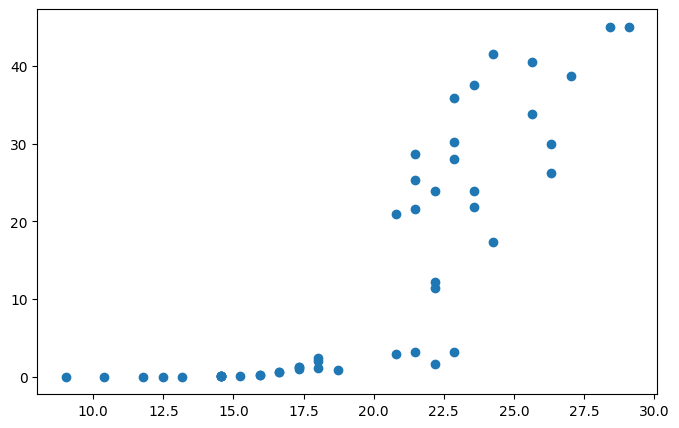

In [60]:
plt.figure(figsize=(8,5))
plt.plot(n_ops, flops, marker='o', linestyle='')
plt.show()